In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json

from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')
pd.set_option('display.max_columns', None)

In [2]:
df=pd.read_csv('../data/interim/spb_house_with_subway.csv')

# feature config

In [3]:
df['date'] = pd.to_datetime(df['date'])

df['YearMonth'] = df['date'].map(lambda x: x.year+(x.month-1)/12)

df['level_proportion'] = (df['level'] - 1) / df['levels']

df.loc[df['rooms']==-1,'rooms'] = 0

df['room_area'] = df['area'] - df['kitchen_area']

studio_index = df.index[df['rooms']==0]
non_studio_index = df.index[df['rooms']!=0]
df.loc[non_studio_index,'area_per_room'] = (df.loc[non_studio_index,'room_area'] 
                                            / df.loc[non_studio_index,'rooms'])
df.loc[studio_index,'area_per_room'] = df.loc[studio_index,'room_area'] 

df.drop(['date', 'time', 'region'], inplace=True, axis=1)

In [4]:
# df.loc[df['SubwayDistance']>=20000, 'StationName'] = 'Без метро'

In [5]:
df.head()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,StationName,SubwayDistance,YearMonth,level_proportion,room_area,area_per_room
0,6050000,59.805808,30.376141,1,8,10,3,82.6,10.8,1,Купчино,2654.808620,2018.083333,0.700000,71.8,23.933333
1,3600000,59.875526,30.395457,1,2,5,1,31.1,6.0,1,Международная,1078.709945,2018.166667,0.200000,25.1,25.100000
2,3200000,59.827465,30.201827,1,7,9,1,31.0,7.0,1,Проспект Ветеранов,3233.926980,2018.250000,0.666667,24.0,24.000000
3,6500000,59.988334,29.786928,3,3,3,3,89.0,10.0,1,Беговая,23096.539408,2018.250000,0.666667,79.0,26.333333
4,6300000,59.911622,30.284556,3,5,5,2,99.9,14.5,1,Балтийская,1101.143050,2018.250000,0.800000,85.4,42.700000


In [6]:
df = df[(df['price']>1e6) & (df['price']<50e6)].reset_index(drop=True)
df = df[(df['area']>12) & (df['area']<400)].reset_index(drop=True)
df = df[(df['kitchen_area']>1.5) & (df['kitchen_area']<80)].reset_index(drop=True)
df = df[df['rooms']>=0].reset_index(drop=True)
df = df[df['level_proportion']<1].reset_index(drop=True)
df = df[df['room_area']>5].reset_index(drop=True)
df = df[df['area_per_room']>5].reset_index(drop=True)
df.drop(df[(df['price']<6.8e6) & (df['area']>150)].index, inplace=True)
df.describe()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,SubwayDistance,YearMonth,level_proportion,room_area,area_per_room
count,4.571410e+05,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000,457141.000000
mean,7.681160e+06,59.932740,30.319731,1.948814,7.594716,14.386940,1.818483,57.279613,12.575743,5.288524,2635.071910,2020.006148,0.446958,44.703870,24.602679
std,5.713301e+06,0.084854,0.120430,0.952119,5.703477,7.072323,0.997522,28.136681,6.472380,4.949127,3865.140443,0.761357,0.280683,24.992409,7.198876
min,1.000300e+06,59.647383,29.509349,0.000000,1.000000,1.000000,0.000000,12.100000,1.600000,1.000000,3.013156,2018.083333,0.000000,5.100000,5.057500
25%,4.400000e+06,59.863270,30.256876,1.000000,3.000000,9.000000,1.000000,37.600000,8.500000,1.000000,740.648746,2019.416667,0.200000,26.400000,20.350000
50%,5.910000e+06,59.939084,30.324338,2.000000,6.000000,13.000000,2.000000,50.700000,11.100000,1.000000,1365.721099,2020.083333,0.440000,39.000000,23.800000
75%,8.718270e+06,59.999856,30.399130,3.000000,11.000000,21.000000,2.000000,68.200000,15.010000,11.000000,3006.007484,2020.583333,0.681818,54.600000,27.600000
max,5.000000e+07,60.241984,30.711428,5.000000,35.000000,38.000000,9.000000,390.000000,79.900000,11.000000,46469.507505,2021.333333,0.971429,359.000000,254.000000


In [7]:

# plt.figure(figsize = (20,10))
# sns.regplot(data=df, x='area', y='price')
# plt.axhline(y=6.8e6, color='Green', linestyle='--', linewidth=3)
# plt.axvline(x=150, color='Green', linestyle='--', linewidth=3)

In [8]:
# plt.figure(figsize = (20,5))
# sns.displot(df,x='room_area')

In [9]:
# plt.figure(figsize = (10,5))
# sns.boxplot(data=np.log10(df['room_area']+1),orient='h')

In [10]:
df.head()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,StationName,SubwayDistance,YearMonth,level_proportion,room_area,area_per_room
0,6050000,59.805808,30.376141,1,8,10,3,82.6,10.8,1,Купчино,2654.808620,2018.083333,0.700000,71.8,23.933333
1,3600000,59.875526,30.395457,1,2,5,1,31.1,6.0,1,Международная,1078.709945,2018.166667,0.200000,25.1,25.100000
2,3200000,59.827465,30.201827,1,7,9,1,31.0,7.0,1,Проспект Ветеранов,3233.926980,2018.250000,0.666667,24.0,24.000000
3,6500000,59.988334,29.786928,3,3,3,3,89.0,10.0,1,Беговая,23096.539408,2018.250000,0.666667,79.0,26.333333
4,6300000,59.911622,30.284556,3,5,5,2,99.9,14.5,1,Балтийская,1101.143050,2018.250000,0.800000,85.4,42.700000


In [11]:
num_categorical_features = ['building_type', 'object_type', 'levels',
#                             'level',
                           ]
df[num_categorical_features] = df[num_categorical_features].astype(str)
# df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457141 entries, 0 to 457227
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             457141 non-null  int64  
 1   geo_lat           457141 non-null  float64
 2   geo_lon           457141 non-null  float64
 3   building_type     457141 non-null  object 
 4   level             457141 non-null  int64  
 5   levels            457141 non-null  object 
 6   rooms             457141 non-null  int64  
 7   area              457141 non-null  float64
 8   kitchen_area      457141 non-null  float64
 9   object_type       457141 non-null  object 
 10  StationName       457141 non-null  object 
 11  SubwayDistance    457141 non-null  float64
 12  YearMonth         457141 non-null  float64
 13  level_proportion  457141 non-null  float64
 14  room_area         457141 non-null  float64
 15  area_per_room     457141 non-null  float64
dtypes: float64(9), int64

In [12]:
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=2707)



In [13]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import make_pipeline, make_union

categorical_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_exclude=object)
num_features = num_selector(X_train)
categorical_trans = make_column_transformer((OneHotEncoder(),categorical_selector))
categorical_trans


ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f97c08acf10>)])

In [14]:
scaler = StandardScaler()
log_transform = FunctionTransformer(np.log1p, validate=True)

num_pipe = make_pipeline(log_transform, scaler)
num_trans = make_column_transformer((num_pipe,num_selector))
num_trans

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f97c08ac0a0>)])

In [15]:
preprocessing = make_union(categorical_trans, num_trans)
preprocessing

FeatureUnion(transformer_list=[('columntransformer-1',
                                ColumnTransformer(transformers=[('onehotencoder',
                                                                 OneHotEncoder(),
                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f97c08acf10>)])),
                               ('columntransformer-2',
                                ColumnTransformer(transformers=[('pipeline',
                                                                 Pipeline(steps=[('functiontransformer',
                                                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                      validate=True)),
                                                                                 ('standardscaler',
                                                                                  StandardScaler())]),
                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f97c08ac0a0>)]))])

In [16]:
# from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor

model1 = GradientBoostingRegressor(n_estimators=200)

reg_struct = [('reg1', model1),
              ('reg2', 'drop'),
              ('reg3', 'drop')]

regressor = VotingRegressor(estimators=reg_struct, n_jobs=-1, verbose=True)
regressor

VotingRegressor(estimators=[('reg1',
                             GradientBoostingRegressor(n_estimators=200)),
                            ('reg2', 'drop'), ('reg3', 'drop')],
                n_jobs=-1, verbose=True)

In [17]:
pipe = make_pipeline(preprocessing, regressor)
pipe

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('columntransformer-1',
                                                 ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f97c08acf10>)])),
                                                ('columntransformer-2',
                                                 ColumnTransformer(transformers=[('pipeline',
                                                                                  Pipeline(steps=[('functiontransformer',
                                                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                                       validate=True)),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f97c08ac0a0>)]))])),
                ('votingregressor',
                 VotingRegressor(estimators=[('reg1',
                                              GradientBoostingRegressor(n_estimators=200)),
                                             ('reg2', 'drop'),
                                             ('reg3', 'drop')],
                                 n_jobs=-1, verbose=True))])

In [18]:
y_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

regr = TransformedTargetRegressor(regressor=pipe,
                                  transformer=y_transformer)
regr

TransformedTargetRegressor(regressor=Pipeline(steps=[('featureunion',
                                                      FeatureUnion(transformer_list=[('columntransformer-1',
                                                                                      ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                       OneHotEncoder(),
                                                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x7f97c08acf10>)])),
                                                                                     ('columntransformer-2',
                                                                                      ColumnTransformer(transformers=[('pipeline',
                                                                                                                       Pipeline(s...
                                                                                                                                       ('standardscaler',
                                                                                                                                        StandardScaler())]),
                                                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x7f97c08ac0a0>)]))])),
                                                     ('votingregressor',
                                                      VotingRegressor(estimators=[('reg1',
                                                                                   GradientBoostingRegressor(n_estimators=200)),
                                                                                  ('reg2',
                                                                                   'drop'),
                                                                                  ('reg3',
                                                                                   'drop')],
                                                                      n_jobs=-1,
                                                                      verbose=True))]),
                           transformer=FunctionTransformer(func=<ufunc 'log1p'>,
                                                           inverse_func=<ufunc 'expm1'>))

In [19]:
# regr.fit(X_train,y_train)
# print('Train R2 score: {0:.2f}'.format(regr.score(X_train, y_train)))
# print('Test R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

In [20]:
from pycaret.regression import *
df_train = df.sample(frac=0.8, random_state= 2707)
df_test = df.drop(df_train.index)

In [21]:
reg = setup(data = df_train,            
            target = 'price',
            categorical_features=['building_type', 'object_type', 'levels',
#                                   'level',
                                  'StationName', 'rooms'],
#             ordinal_features={'rooms':[0,1,2,3,4,5,6,7,8,9]},
            train_size= 0.75,
            
            preprocess = True,
            
            normalize = True,
            normalize_method='zscore',
            transformation=True,
            
            pca = False,
            pca_components=None,
            
            remove_outliers=False,
            remove_perfect_collinearity=False,
            transform_target=True,
            
            fold_strategy='kfold',
            fold=2,
            
            silent = True,
            )

,Description,Value
0,session_id,8174
1,Target,price
2,Original Data,"(365713, 16)"
3,Missing Values,0
4,Numeric Features,10
5,Categorical Features,5
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(274284, 140)"


In [22]:
# top3 = compare_models(n_select=3)

In [23]:
lgbm = create_model('lightgbm',
                    fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1073430.9342,4803045295721.2607,2191585.1103,0.8511,0.1869,0.1300
1,1061882.8787,4766239581471.2363,2183171.9084,0.8508,0.1842,0.1276
2,1067229.8426,4739056398920.5039,2176937.3898,0.8560,0.1873,0.1299
3,1044739.5888,4370302206716.4927,2090526.7773,0.8655,0.1836,0.1281
4,1079494.9349,4879692578966.9551,2209002.6209,0.8559,0.1838,0.1279
5,1063565.5999,4483578167931.2383,2117446.1429,0.8629,0.1852,0.1294
6,1059864.6422,4540195105703.3418,2130773.3586,0.8622,0.1813,0.1268
7,1053884.5494,4483047584489.5791,2117320.8506,0.8605,0.1831,0.1273
8,1067029.1311,4611882555942.2744,2147529.4075,0.8600,0.1854,0.1291
9,1076992.2758,4623888359266.4736,2150322.8500,0.8584,0.1877,0.1318


In [24]:
tuned_lgbm = tune_model(lgbm,
                        early_stopping=True,
                        optimize='R2',
                        search_library='optuna',
                        fold=4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,927378.7923,3797135538636.3926,1948624.0116,0.8830,0.1689,0.1126
1,919730.7690,3723076375794.1543,1929527.5007,0.8870,0.1666,0.1114
2,920319.1577,3593014946272.4092,1895524.9791,0.8894,0.1652,0.1110
3,928509.6454,3734970374997.6650,1932607.1445,0.8864,0.1698,0.1136
Mean,923984.5911,3712049308925.1553,1926570.9090,0.8864,0.1676,0.1121
SD,3985.1952,74256005568.9987,19334.9856,0.0023,0.0018,0.0010


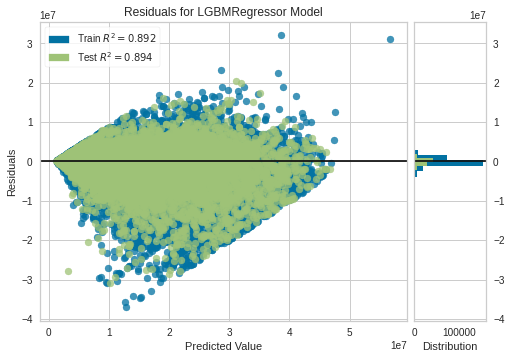

In [25]:
final_lgbm = finalize_model(tuned_lgbm)
plot_model(final_lgbm)

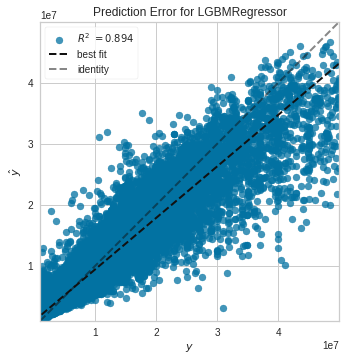

In [26]:
plot_model(final_lgbm, plot='error')

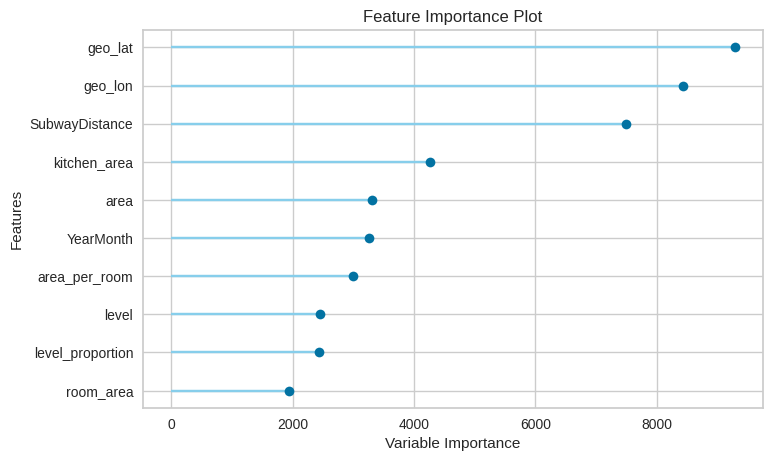

In [27]:
plot_model(final_lgbm, plot='feature')

In [28]:
catboost = create_model('catboost',
                        fold=2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,939784.3911,3949417060456.7935,1987314.0317,0.8792,0.1702,0.1145
1,941335.2527,3713464571978.3926,1927035.1766,0.8864,0.1699,0.1151
Mean,940559.8219,3831440816217.5928,1957174.6041,0.8828,0.1701,0.1148
SD,775.4308,117976244239.2004,30139.4275,0.0036,0.0002,0.0003


In [29]:
# tuned_catboost = tune_model(catboost,
# #                             early_stopping=True,
#                             optimize='R2',
#                             search_library='optuna',
#                             fold=4)

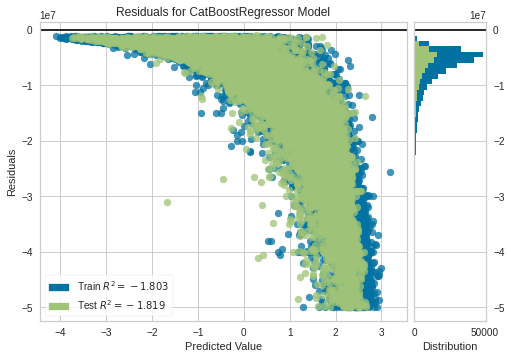

In [30]:
# final_catboost = finalize_model(catboost)
plot_model(catboost)

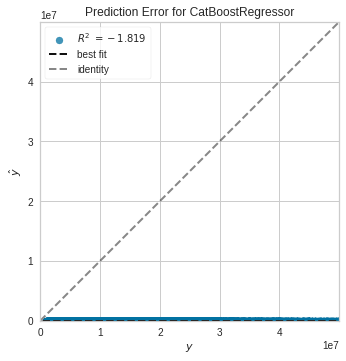

In [31]:
plot_model(catboost, 'error')

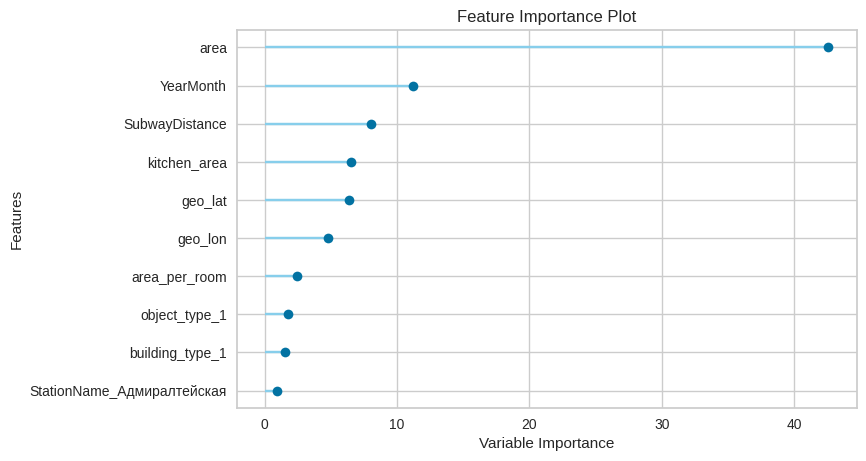

In [32]:
plot_model(catboost, 'feature')

In [33]:
blend_soft = blend_models(estimator_list=[tuned_lgbm, catboost])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,917773.0744,3745928097824.2119,1935440.0269,0.8854,0.1677,0.1119
1,919332.3710,3587330996452.5825,1894025.0781,0.8902,0.1671,0.1122
Mean,918552.7227,3666629547138.3975,1914732.5525,0.8878,0.1674,0.1121
SD,779.6483,79298550685.8147,20707.4744,0.0024,0.0003,0.0002


In [34]:
final_blend = finalize_model(blend_soft)

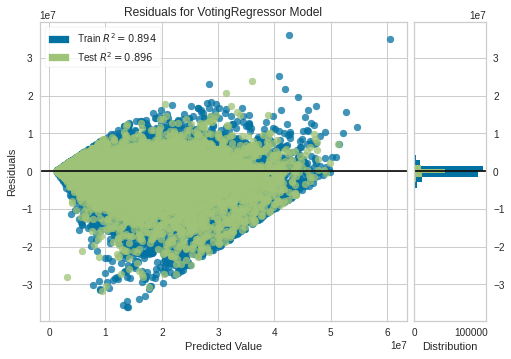

In [35]:
plot_model(final_blend)

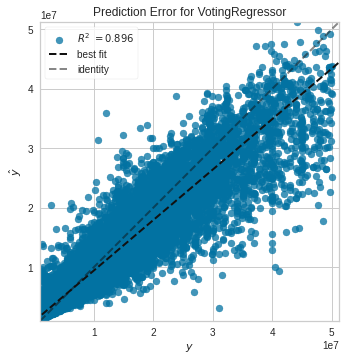

In [36]:
plot_model(final_blend,'error')